In [2]:
pip install tensorflow==2.8.1 tensorflow-gpu==2.8.1 opencv-python mediapipe scikit-learn matplotlib

Note: you may need to restart the kernel to use updated packages.


In [3]:
import cv2
from tensorflow.keras.optimizers import Adam
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp

In [4]:
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils

In [5]:
#เปลี่ยน BGR เป็น RGB
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False
    results = model.process(image)
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    return image, results

In [6]:
#กำหนดlandmark
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS)
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS)
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS)
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS)

In [7]:
#customตัวlandmark
def draw_styled_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS,
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1),
                              mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                             )
    
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4),
                              mp_drawing.DrawingSpec(color=(80,244,121), thickness=2, circle_radius=2)
                             )
    
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4),
                              mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             )
    
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4),
                              mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             )

In [8]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(132)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(1404)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])

In [9]:
DATA_PATH= os.path.join('AruchaSuckCock')

actions = np.array(['สวัสดี', 'ตก', 'รอ', 'กลับ', 'ขอบคุณ', 'ตัด', 'ลง', 'ขึ้น', 'เฝ้า','คุย', 'ช่วย', 'เชื่อ', 'ฟัง', 'มอง', 'พา', 'ชวน หลีกภัย', 'ทักษิณ ชินวัตร', 'ขนม', 'พิธา ลิ้มเจริญรัตน์', 'ศิริกัญญา ตันสกุล','แบก', 'อนุทิน ชาญวีรกูล', 'รังสิมันต์ โรม', 'พีระพันธุ์ สาลีรัฐวิภาค', 'คุณหญิงสุดารัตน์ เกยุราพันธุ์', 'พลเอกอนุพงษ์ เผ่าจินดา', 'สุวัจน์ ลิปตพัลลภ', 'กรณ์ จาติกวณิช', 'วราวุธ ศิลปะอาชา', 'พล.ต.อ.เสรีพิศุทธ์ เตมียเวสวราวุธ ศิลปะอาชา', 'ศักดิ์สยาม ชิดชอบ', 'ชาดา ไทยเศรษฐ์', 'สุชัชวีร์ สุวรรณสวัสดิ์', 'จุรินทร์ ลักษณวิศิษฏ์', 'ไตรรงค์ สุวรรณคีรี', 'พลเอกประยุทธ์ จันทร์โอชา', 'นฤมล ภิญโญสินวัฒน์', 'ธรรมนัส พรหมเผ่า', 'ชัยวุฒิ ธนาคมานุสรณ์', 'ไพบูลย์ นิติตะวัน', 'พลเอกประวิตร วงษ์สุวรรณ', 'พริษฐ์ วัชรสินธุ', 'ยิ่งลักษณ์ ชินวัตร', 'ณัฐวุฒิ ใสยเกื้อ', 'นพ.ชลน่าน ศรีแก้ว', 'เศรษฐา ทวีสิน', 'แพทองธาร ชินวัตร', 'อะไร', 'สมัคร', 'กระโดด', 'ยก', 'ชน', 'ผ่าน', 'แนะนำ', 'จำได้', 'ปลูก', 'รวม', 'ทำหาย', 'เจอ', 'หาย', 'พนักงานขาย', 'นักเขียนโปรแกรม', 'พ่อครัว', 'เจ้าหน้าที่ตำรวจ', 'เนื้อลูกแกะ', 'เนื้อหมู', 'คุณสบายดีไหม', 'ดูเหมือน', 'วาง', 'อยู่', 'ก', 'ข', 'ค', 'ฆ', 'ต', 'ถ', 'ง', 'จ', 'ฉ', 'ช', 'ซ', 'ฏ', 'ฐ', 'ฑ', 'ฒ', 'ณ', 'ด', 'ท', 'ธ', 'น', 'บ', 'ป', 'ผ', 'ฝ', 'พ', 'ฟ', 'ภ', 'ม', 'ย', 'ร', 'ล', 'ว', 'ศ', 'ษ', 'ส', 'ห', 'ฬ', 'อ', 'ฮ'])

# 30 videos of data
no_sequences = 30

# videos are 30 frames length
sequence_length = 30

In [10]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [11]:
label_map = {label:num for num, label in enumerate(actions)}

In [12]:
sequences, labels = [], []
for action in actions:
    for sequence in range(no_sequences):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [13]:
len(sequences)

3270

In [14]:
X = np.array(sequences)

In [15]:
y = to_categorical(labels).astype(int)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

In [17]:
y_train.shape
y_test.shape

(164, 109)

In [18]:
X_train.shape

(3106, 30, 1662)

In [19]:
X[0][0].shape

# Why is the format of this input 30 * 1662?

(1662,)

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard

In [21]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

model_alternative = Sequential()
model_alternative.add(LSTM(256, return_sequences=False, activation='relu', input_shape=(30, 1662), dropout=0.2))
model_alternative.add(Dense(109, activation='softmax')) #cheating on size

In [22]:
learning_rate = 0.0001

optimizer = Adam(learning_rate=learning_rate)
model_alternative.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [23]:
model_alternative.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 256)               1965056   
                                                                 
 dense (Dense)               (None, 109)               28013     
                                                                 
Total params: 1,993,069
Trainable params: 1,993,069
Non-trainable params: 0
_________________________________________________________________


In [24]:
model_alternative.fit(X_train, y_train, epochs=300, callbacks=[tb_callback],validation_data=(X_test, y_test), batch_size=16)

Epoch 1/300
195/195 [==============================] - 19s 91ms/step - loss: 4.5808 - categorical_accuracy: 0.0283 - val_loss: 4.3169 - val_categorical_accuracy: 0.0305
Epoch 2/300
195/195 [==============================] - 16s 83ms/step - loss: 3.9517 - categorical_accuracy: 0.0769 - val_loss: 3.6641 - val_categorical_accuracy: 0.0549
Epoch 3/300
195/195 [==============================] - 16s 83ms/step - loss: 3.3232 - categorical_accuracy: 0.1494 - val_loss: 3.5125 - val_categorical_accuracy: 0.1463
Epoch 4/300
195/195 [==============================] - 16s 84ms/step - loss: 2.6941 - categorical_accuracy: 0.2466 - val_loss: 2.4080 - val_categorical_accuracy: 0.3720
Epoch 5/300
195/195 [==============================] - 16s 82ms/step - loss: 2.2979 - categorical_accuracy: 0.3033 - val_loss: 2.0307 - val_categorical_accuracy: 0.3780
Epoch 6/300
195/195 [==============================] - 16s 82ms/step - loss: 1.9660 - categorical_accuracy: 0.3783 - val_loss: 1.5570 - val_categorical_acc

KeyboardInterrupt: 

In [25]:
yhat = model_alternative.predict(X_test)

In [26]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [27]:
from sklearn.metrics import accuracy_score

In [28]:
accuracy_score(ytrue, yhat)

0.926829268292683

In [29]:
from sklearn.metrics import ConfusionMatrixDisplay,multilabel_confusion_matrix, classification_report, confusion_matrix
# cm = multilabel_confusion_matrix(ytrue, yhat)
cm = confusion_matrix(ytrue, yhat)
cm

array([[5, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 2, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [30]:
print(classification_report(ytrue, yhat))

              precision    recall  f1-score   support

           0       1.00      0.83      0.91         6
           1       0.00      0.00      0.00         0
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00         3
           4       1.00      1.00      1.00         1
           5       1.00      0.75      0.86         4
           6       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         0
           8       1.00      1.00      1.00         1
           9       1.00      1.00      1.00         1
          10       1.00      1.00      1.00         2
          11       1.00      1.00      1.00         1
          12       1.00      1.00      1.00         2
          13       1.00      1.00      1.00         2
          14       1.00      1.00      1.00         1
          15       0.00      0.00      0.00         1
          16       0.50      1.00      0.67         1
          17       1.00    

C:\Users\phira\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\phira\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\phira\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\phira\anaconda3\lib\site-packages\sklearn\metrics\_cla

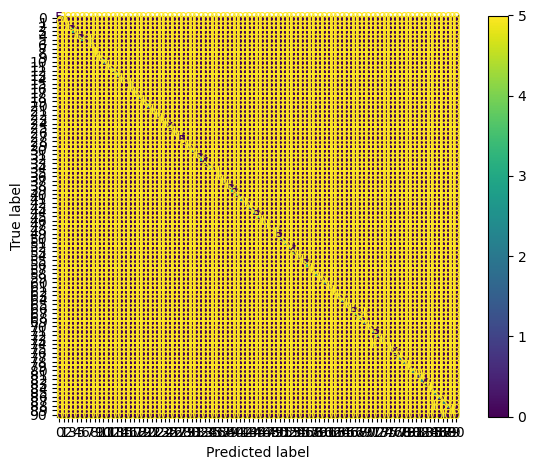

In [31]:
plt.rcParams['figure.figsize'] = (80, 80)
plt.rcParams['figure.dpi'] = 100

fig, ax = plt.subplots()

disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot(ax=ax)

plt.tight_layout()


plt.show()

In [32]:
model_alternative.save('action2.h5')


# ใช้จริง

In [ ]:
from PIL import ImageFont, Image, ImageDraw

In [ ]:
colors = [(245, 117, 16), (117, 245, 16), (16, 117, 245)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input-frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0, 60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    return output_frame

In [ ]:
sequence = []
sentence = []
predictions = []
threshold = 0.9

cap = cv2.VideoCapture(0)
#set mediapipe model
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        ret, frame = cap.read()

        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        draw_styled_landmarks(image, results)
        
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))
            
            if np.unique(predictions[-10:])[0]==np.argmax(res):
                if res[np.argmax(res)] > threshold:

                    if len(sequence) > 0:
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])
        
            if len(sentence) > 5:
                sentence = sentence[-5:]

            image = prob_viz(res, actions, image, colors)

        cv2.rectangle(image, (0,0), (640,40), (245, 117, 16), -1)
        
        fontpath = "./angsana.ttc"
        font = ImageFont.truetype(fontpath, 30)
        img_pil = Image.fromarray(image)
        draw = ImageDraw.Draw(img_pil)
        draw.text((50, 80),  ''.join(sentence), font = font, fill = (b, g, r, a))
        image = np.array(img_pil)
        #cv2.putText(image, ''.join(sentence), (3, 30),
                    #cv2.FONT_HERSHEY_SIMPLEX, 0, (255, 255, 255), 2, cv2.LINE_AA)
        
        

        cv2.imshow('OpenCV video test', image)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()